=== High-Accuracy Indian Food Classifier ===
Optimized for high accuracy and low CPU usage

1. Loading dataset...
Loading dataset...
Loading class: Roshmalai
  Loaded 100 images (with augmentation: 400) from Roshmalai
Loading class: Kalavuna
  Loaded 100 images (with augmentation: 400) from Kalavuna
Loading class: Fuchka
  Loaded 100 images (with augmentation: 400) from Fuchka
Loading class: Pitha
  Loaded 100 images (with augmentation: 400) from Pitha
Loading class: Jhalmuri
  Loaded 100 images (with augmentation: 400) from Jhalmuri
Loading class: Shingara
  Loaded 100 images (with augmentation: 400) from Shingara
Loading class: Mishti
  Loaded 100 images (with augmentation: 400) from Mishti
Loading class: Khichuri
  Loaded 100 images (with augmentation: 400) from Khichuri
Loading class: Puri
  Loaded 100 images (with augmentation: 400) from Puri
Loading class: Sugarcane Juice
  Loaded 100 images (with augmentation: 400) from Sugarcane Juice
Total: 4000 images from 10 classes

Class d

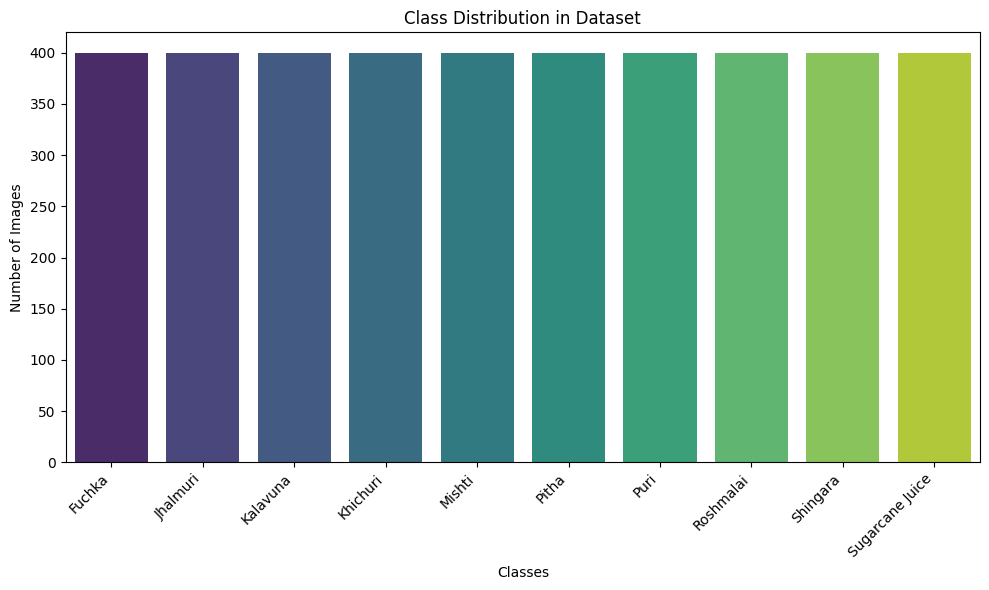


2. Preprocessing images...
Preprocessing images...
Preprocessing 0/4000
Preprocessing 50/4000
Preprocessing 100/4000
Preprocessing 150/4000
Preprocessing 200/4000
Preprocessing 250/4000
Preprocessing 300/4000
Preprocessing 350/4000
Preprocessing 400/4000
Preprocessing 450/4000
Preprocessing 500/4000
Preprocessing 550/4000
Preprocessing 600/4000
Preprocessing 650/4000
Preprocessing 700/4000
Preprocessing 750/4000
Preprocessing 800/4000
Preprocessing 850/4000
Preprocessing 900/4000
Preprocessing 950/4000
Preprocessing 1000/4000
Preprocessing 1050/4000
Preprocessing 1100/4000
Preprocessing 1150/4000
Preprocessing 1200/4000
Preprocessing 1250/4000
Preprocessing 1300/4000
Preprocessing 1350/4000
Preprocessing 1400/4000
Preprocessing 1450/4000
Preprocessing 1500/4000
Preprocessing 1550/4000
Preprocessing 1600/4000
Preprocessing 1650/4000
Preprocessing 1700/4000
Preprocessing 1750/4000
Preprocessing 1800/4000
Preprocessing 1850/4000
Preprocessing 1900/4000
Preprocessing 1950/4000
Preprocessi

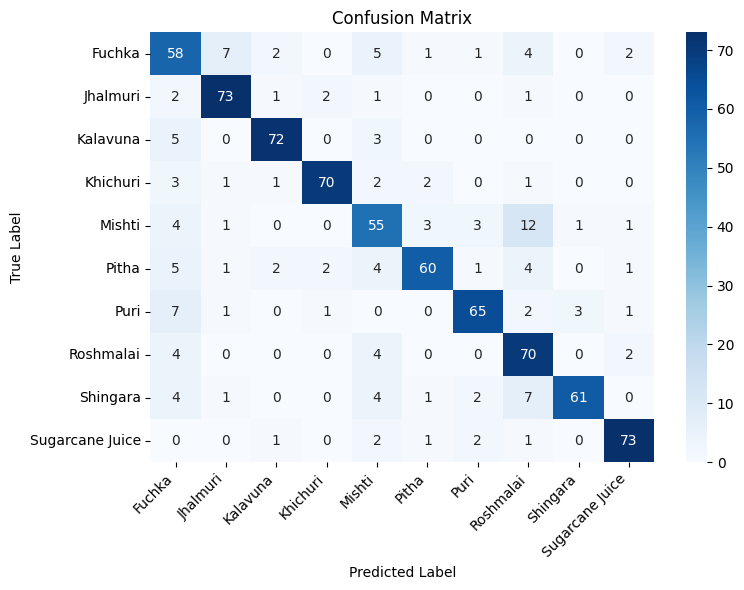

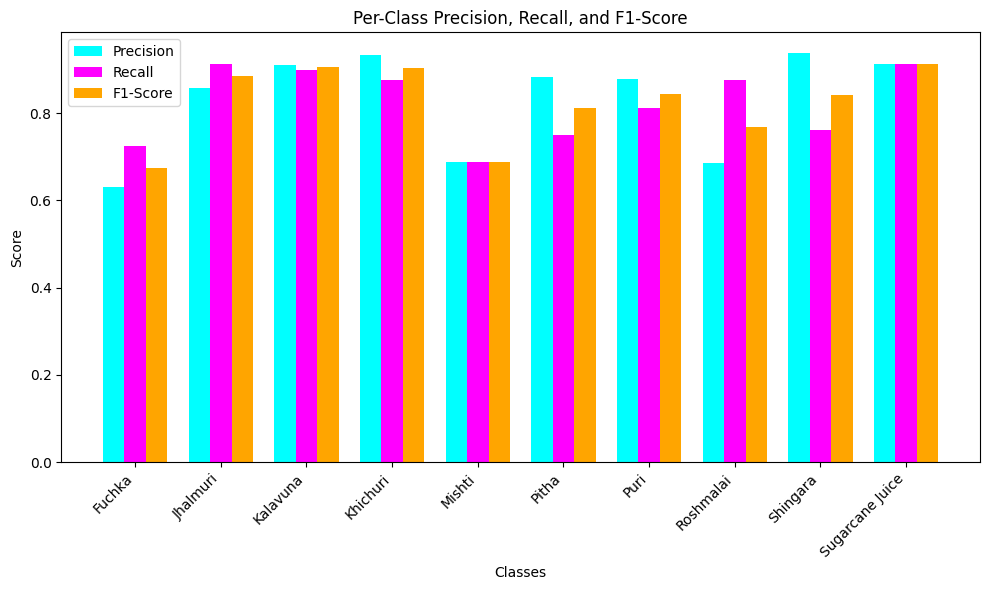

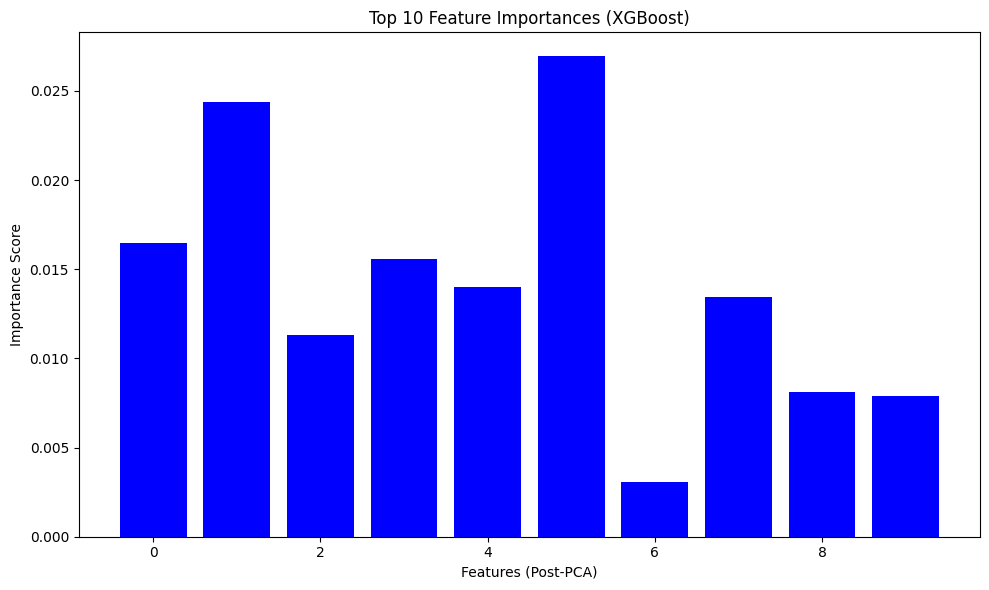

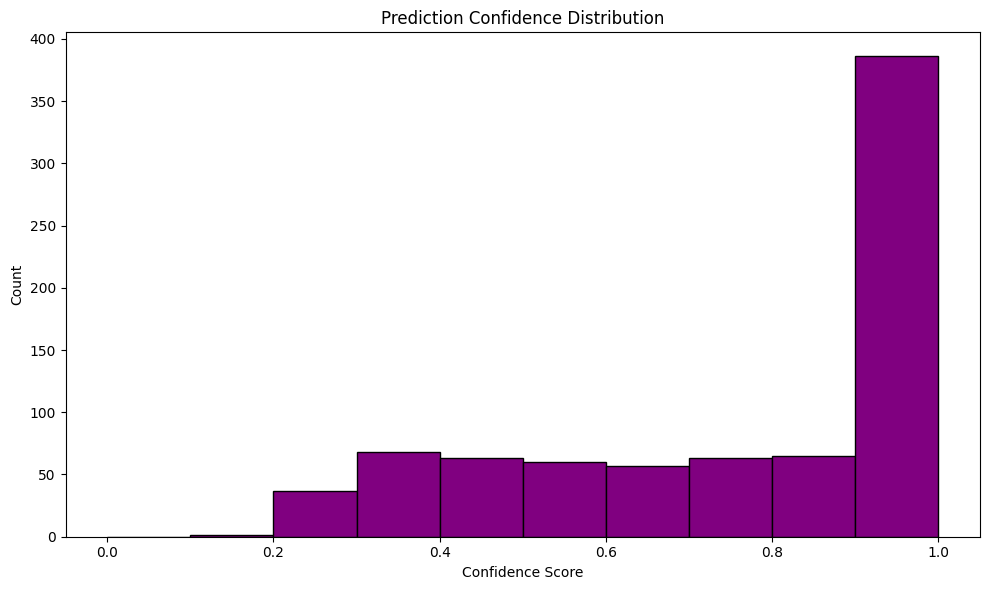


7. Saving model...
Model saved to optimized_indian_food_classifier.pkl

Training completed successfully!
Final accuracy: 82.12%
Total training time: 52.49 seconds


In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import cv2
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from skimage.transform import rotate
import pickle
import warnings
import xgboost as xgb
import time
import gc
warnings.filterwarnings('ignore')

class OptimizedIndianFoodClassifier:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=0.98)
        self.best_model = None
        self.class_names = []
        
    def augment_image(self, img):
        """Lightweight data augmentation: rotation and flipping"""
        augmented_images = [img]
        augmented_images.append(rotate(img, angle=10, preserve_range=True).astype(np.uint8))
        augmented_images.append(rotate(img, angle=-10, preserve_range=True).astype(np.uint8))
        augmented_images.append(np.fliplr(img))
        return augmented_images
    
    def load_dataset(self, max_images_per_class=100):
        """Load images with augmentation and plot class distribution"""
        print("Loading dataset...")
        images = []
        labels = []
        
        for class_name in os.listdir(self.dataset_path):
            class_path = os.path.join(self.dataset_path, class_name)
            if os.path.isdir(class_path):
                self.class_names.append(class_name)
                print(f"Loading class: {class_name}")
                count = 0
                
                for img_file in os.listdir(class_path):
                    if count >= max_images_per_class:
                        break
                        
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                        img_path = os.path.join(class_path, img_file)
                        try:
                            img = Image.open(img_path)
                            if img.mode != 'RGB':
                                img = img.convert('RGB')
                            img_array = np.array(img)
                            augmented_imgs = self.augment_image(img_array)
                            images.extend(augmented_imgs)
                            labels.extend([class_name] * len(augmented_imgs))
                            count += 1
                        except Exception as e:
                            print(f"Error loading {img_path}: {e}")
                            
                print(f"  Loaded {count} images (with augmentation: {count * 4}) from {class_name}")
        
        self.images = np.array(images, dtype=object)
        self.labels = np.array(labels)
        print(f"Total: {len(self.images)} images from {len(set(self.labels))} classes")
        
        unique, counts = np.unique(self.labels, return_counts=True)
        print("\nClass distribution:")
        for cls, count in zip(unique, counts):
            print(f"  {cls}: {count} images")
        
        # Plot class distribution using matplotlib
        plt.figure(figsize=(10, 6))
        sns.barplot(x=unique, y=counts, palette='viridis')
        plt.title('Class Distribution in Dataset')
        plt.xlabel('Classes')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        return self.images, self.labels
    
    def preprocess_images(self, target_size=(100, 100)):
        """Lightweight preprocessing with improved contrast"""
        print("Preprocessing images...")
        processed_images = []
        
        for i, img in enumerate(self.images):
            if i % 50 == 0:
                print(f"Preprocessing {i}/{len(self.images)}")
            
            img_resized = cv2.resize(img, target_size)
            img_lab = cv2.cvtColor(img_resized, cv2.COLOR_RGB2LAB)
            clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(4, 4))
            img_lab[:, :, 0] = clahe.apply(img_lab[:, :, 0])
            img_enhanced = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
            
            processed_images.append(img_enhanced)
        
        self.processed_images = np.array(processed_images)
        print(f"Preprocessed images shape: {self.processed_images.shape}")
        
        del self.images
        gc.collect()
        
        return self.processed_images
    
    def extract_optimized_features(self):
        """Extract enhanced but efficient features"""
        print("Extracting optimized features...")
        all_features = []
        
        for idx, img in enumerate(self.processed_images):
            if idx % 100 == 0:
                print(f"Processing image {idx}/{len(self.processed_images)}")
            
            features = []
            
            for channel in range(3):
                hist = cv2.calcHist([img], [channel], None, [32], [0, 256])
                features.extend(hist.flatten())
            
            hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            for channel in range(3):
                hist = cv2.calcHist([hsv], [channel], None, [16], [0, 256])
                features.extend(hist.flatten())
            
            for channel in range(3):
                channel_data = img[:, :, channel].flatten()
                features.extend([
                    np.mean(channel_data),
                    np.std(channel_data),
                    np.percentile(channel_data, 50)
                ])
            
            gray = rgb2gray(img)
            gray_uint8 = (gray * 255).astype(np.uint8)
            for radius in [1, 2]:
                lbp = local_binary_pattern(gray, P=8*radius, R=radius, method='uniform')
                lbp_hist, _ = np.histogram(lbp.ravel(), bins=12, range=(0, 12))
                features.extend(lbp_hist)
            
            hog_features = hog(gray, orientations=6, pixels_per_cell=(16, 16),
                             cells_per_block=(2, 2), transform_sqrt=True)
            features.extend(hog_features)
            
            features.extend([
                np.mean(img),
                np.std(img)
            ])
            
            all_features.append(features)
        
        self.features = np.array(all_features)
        print(f"Extracted features shape: {self.features.shape}")
        
        del self.processed_images
        gc.collect()
        
        return self.features
    
    def prepare_data(self):
        """Prepare data for training"""
        print("Preparing data...")
        
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)
        self.features = np.nan_to_num(self.features, nan=0, posinf=0, neginf=0)
        self.scaled_features = self.scaler.fit_transform(self.features)
        self.pca_features = self.pca.fit_transform(self.scaled_features)
        
        print(f"Features after PCA: {self.pca_features.shape}")
        print(f"Explained variance ratio: {self.pca.explained_variance_ratio_.sum():.3f}")
        
        del self.features, self.scaled_features
        gc.collect()
        
        return self.pca_features, self.encoded_labels
    
    def train_fast_model(self, test_size=0.2):
        """Train XGBoost with class weighting"""
        print("Training optimized model...")
        
        X_train, X_test, y_train, y_test = train_test_split(
            self.pca_features, self.encoded_labels, 
            test_size=test_size, random_state=42, stratify=self.encoded_labels
        )
        
        unique, counts = np.unique(y_train, return_counts=True)
        class_weights = {i: max(counts) / count for i, count in zip(unique, counts)}
        
        print("Training XGBoost...")
        start_time = time.time()
        xgb_model = xgb.XGBClassifier(
            objective='multi:softprob',
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42,
            n_jobs=-1
        )
        xgb_model.fit(X_train, y_train, sample_weight=[class_weights[y] for y in y_train])
        xgb_score = xgb_model.score(X_test, y_test)
        
        self.best_model = xgb_model
        print(f"XGBoost trained in {time.time() - start_time:.2f}s - Accuracy: {xgb_score:.3f}")
        
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = self.best_model.predict(X_test)
        
        return self.best_model
    
    def evaluate_model(self):
        """Evaluate the model and generate visualization plots"""
        print("Evaluating model...")
        
        accuracy = accuracy_score(self.y_test, self.y_pred)
        print(f"Test Accuracy: {accuracy:.3f}")
        
        class_names = self.label_encoder.classes_
        print("\nClassification Report:")
        clf_report = classification_report(self.y_test, self.y_pred, target_names=class_names, output_dict=True)
        print(classification_report(self.y_test, self.y_pred, target_names=class_names))
        
        # 1. Confusion Matrix (if ≤10 classes)
        if len(class_names) <= 10:
            cm = confusion_matrix(self.y_test, self.y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=class_names, yticklabels=class_names)
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
        
        # 2. Precision, Recall, F1-Score Bar Plot
        precision = [clf_report[cls]['precision'] for cls in class_names]
        recall = [clf_report[cls]['recall'] for cls in class_names]
        f1_score = [clf_report[cls]['f1-score'] for cls in class_names]
        
        x = np.arange(len(class_names))
        width = 0.25
        plt.figure(figsize=(10, 6))
        plt.bar(x - width, precision, width, label='Precision', color='cyan')
        plt.bar(x, recall, width, label='Recall', color='magenta')
        plt.bar(x + width, f1_score, width, label='F1-Score', color='orange')
        plt.xlabel('Classes')
        plt.ylabel('Score')
        plt.title('Per-Class Precision, Recall, and F1-Score')
        plt.xticks(x, class_names, rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # 3. Feature Importance Plot
        feature_importance = self.best_model.feature_importances_
        feature_indices = np.arange(len(feature_importance))[:10]  # Top 10 features
        plt.figure(figsize=(10, 6))
        plt.bar(feature_indices, feature_importance[:10], color='blue')
        plt.title('Top 10 Feature Importances (XGBoost)')
        plt.xlabel('Features (Post-PCA)')
        plt.ylabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # 4. Prediction Confidence Histogram
        confidences = self.best_model.predict_proba(self.X_test).max(axis=1)
        plt.figure(figsize=(10, 6))
        plt.hist(confidences, bins=10, range=(0, 1), color='purple', edgecolor='black')
        plt.title('Prediction Confidence Distribution')
        plt.xlabel('Confidence Score')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
        
        return accuracy
    
    def predict_new_image(self, image_path):
        """Predict class for a new image"""
        try:
            img = Image.open(image_path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img_array = np.array(img)
            
            img_resized = cv2.resize(img_array, (100, 100))
            img_lab = cv2.cvtColor(img_resized, cv2.COLOR_RGB2LAB)
            clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(4, 4))
            img_lab[:, :, 0] = clahe.apply(img_lab[:, :, 0])
            img_enhanced = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
            
            features = self._extract_single_image_features(img_enhanced)
            
            features = np.array(features).reshape(1, -1)
            features = np.nan_to_num(features, nan=0, posinf=0, neginf=0)
            scaled_features = self.scaler.transform(features)
            pca_features = self.pca.transform(scaled_features)
            
            prediction = self.best_model.predict(pca_features)[0]
            probabilities = self.best_model.predict_proba(pca_features)[0]
            
            predicted_class = self.label_encoder.inverse_transform([prediction])[0]
            confidence = np.max(probabilities)
            
            top_3_indices = np.argsort(probabilities)[-3:][::-1]
            top_3_classes = self.label_encoder.inverse_transform(top_3_indices)
            top_3_probs = probabilities[top_3_indices]
            
            print(f"\nPrediction Results:")
            print(f"Predicted Class: {predicted_class}")
            print(f"Confidence: {confidence:.3f}")
            print(f"\nTop 3 Predictions:")
            for i, (cls, prob) in enumerate(zip(top_3_classes, top_3_probs)):
                print(f"{i+1}. {cls}: {prob:.3f}")
            
            return predicted_class, confidence
            
        except Exception as e:
            print(f"Error predicting image: {e}")
            return None, None
    
    def _extract_single_image_features(self, img):
        """Extract features for a single image"""
        features = []
        
        for channel in range(3):
            hist = cv2.calcHist([img], [channel], None, [32], [0, 256])
            features.extend(hist.flatten())
        
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        for channel in range(3):
            hist = cv2.calcHist([hsv], [channel], None, [16], [0, 256])
            features.extend(hist.flatten())
        
        for channel in range(3):
            channel_data = img[:, :, channel].flatten()
            features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.percentile(channel_data, 50)
            ])
        
        gray = rgb2gray(img)
        gray_uint8 = (gray * 255).astype(np.uint8)
        
        for radius in [1, 2]:
            lbp = local_binary_pattern(gray, P=8*radius, R=radius, method='uniform')
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=12, range=(0, 12))
            features.extend(lbp_hist)
        
        hog_features = hog(gray, orientations=6, pixels_per_cell=(16, 16),
                          cells_per_block=(2, 2), transform_sqrt=True)
        features.extend(hog_features)
        
        features.extend([
            np.mean(img),
            np.std(img)
        ])
        
        return features
    
    def save_model(self, model_path='optimized_indian_food_classifier.pkl'):
        """Save the trained model and preprocessors"""
        model_data = {
            'best_model': self.best_model,
            'label_encoder': self.label_encoder,
            'scaler': self.scaler,
            'pca': self.pca,
            'class_names': self.class_names
        }
        
        with open(model_path, 'wb') as f:
            pickle.dump(model_data, f)
        
        print(f"Model saved to {model_path}")
    
    def load_model(self, model_path='optimized_indian_food_classifier.pkl'):
        """Load a trained model"""
        with open(model_path, 'rb') as f:
            model_data = pickle.load(f)
        
        self.best_model = model_data['best_model']
        self.label_encoder = model_data['label_encoder']
        self.scaler = model_data['scaler']
        self.pca = model_data['pca']
        self.class_names = model_data['class_names']
        
        print("Model loaded successfully!")

def main():
    dataset_path = 'Indian Food Images'  # Update this path
    
    print("=== High-Accuracy Indian Food Classifier ===")
    print("Optimized for high accuracy and low CPU usage")
    print("=" * 50)
    
    classifier = OptimizedIndianFoodClassifier(dataset_path)
    
    print("\n1. Loading dataset...")
    images, labels = classifier.load_dataset(max_images_per_class=100)
    
    print("\n2. Preprocessing images...")
    processed_images = classifier.preprocess_images(target_size=(100, 100))
    
    print("\n3. Extracting features...")
    features = classifier.extract_optimized_features()
    
    print("\n4. Preparing data...")
    X, y = classifier.prepare_data()
    
    print("\n5. Training model...")
    start_time = time.time()
    best_model = classifier.train_fast_model()
    training_time = time.time() - start_time
    
    print("\n6. Evaluating model...")
    accuracy = classifier.evaluate_model()
    
    print("\n7. Saving model...")
    classifier.save_model()
    
    print(f"\n{'='*50}")
    print(f"Training completed successfully!")
    print(f"Final accuracy: {accuracy * 100:.2f}%")
    print(f"Total training time: {training_time:.2f} seconds")
    print(f"{'='*50}")

if __name__ == "__main__":
    main()